<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [73]:
import pandas as pd

In [74]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [75]:
expected_categories = {
    'experience_level': {'SE', 'MI', 'EN', 'EX'},
    'employment_type': {'FT', 'PT', 'CT', 'FL'},
    'remote_ratio': {0, 50, 100},
    'company_size': {'S', 'M', 'L'}
}

for column, valid_values in expected_categories.items():
    actual_values = set(df[column].unique())
    invalid_values = actual_values - valid_values

    if invalid_values:
        print(f"Ошибки в '{column}': {invalid_values}")
    else:
        print(f"'{column}' — все значения корректны")

'experience_level' — все значения корректны
'employment_type' — все значения корректны
'remote_ratio' — все значения корректны
'company_size' — все значения корректны


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [76]:
missing = df.isnull().sum().loc[lambda x: x > 0]  
print('Пропущенных значений нет.' if missing.empty else missing)

Пропущенных значений нет.


In [77]:
print(f'Число дубликатов: {df.duplicated().sum()}')  
df = df.drop_duplicates() if df.duplicated().any() else df

Число дубликатов: 1171


In [78]:
invalid_salaries = df['salary_in_usd'] < 0  
if invalid_salaries.any():
    print(f'Найдены отрицательные зарплаты:\n{df[invalid_salaries]}')
else: 
    print('Отрицательных зарплат нет.')
df = df[~invalid_salaries]

Отрицательных зарплат нет.


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2584 non-null   int64 
 1   experience_level    2584 non-null   object
 2   employment_type     2584 non-null   object
 3   job_title           2584 non-null   object
 4   salary              2584 non-null   int64 
 5   salary_currency     2584 non-null   object
 6   salary_in_usd       2584 non-null   int64 
 7   employee_residence  2584 non-null   object
 8   remote_ratio        2584 non-null   int64 
 9   company_location    2584 non-null   object
 10  company_size        2584 non-null   object
dtypes: int64(4), object(7)
memory usage: 242.2+ KB


In [80]:
print('Типы данных соответстуют ожидаемым')

Типы данных соответстуют ожидаемым


## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [81]:
categorical_columns = df.select_dtypes(exclude=['int']).columns
unique_counts = {col: df[col].nunique() for col in categorical_columns}
sorted_unique_counts = sorted(unique_counts.items(), key=lambda item: item[1], reverse=True)
sorted_unique_counts
# больше всего категорий в job_title, employee_residence и company_location

[('job_title', 93),
 ('employee_residence', 78),
 ('company_location', 72),
 ('salary_currency', 20),
 ('experience_level', 4),
 ('employment_type', 4),
 ('company_size', 3)]

In [82]:
df = df.drop(['salary', 'salary_currency'], axis=1)

#### Все признаки соотвествуют постановке задачи, но считаю что лишними является зарплата по валюте страны и соотв. валюта страны. Есть зарплата конвертированная в доллары - ее достаточно.

больше всего категорий в job_title, employee_residence и company_location

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('salary_in_usd', axis=1), df['salary_in_usd'], test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [84]:
cont_columns = df.select_dtypes(include=['int']).columns.difference(['salary_in_usd'])

X_train_cont, X_test_cont = X_train[cont_columns], X_test[cont_columns]
X_train_all, X_test_all = X_train, X_test

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

model = LinearRegression()
model.fit(X_train_cont, y_train)

y_pred = model.predict(X_test_cont)

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

MAPE: 0.8291
RMSE: 64000.5326


У модели высокое значение MAPE, значит что предсказания в среднем отклоняются на 82,91% от реальных значений - это плохо. RMSE также очень большой, что говорит о значительных ошибках в предсказаниях и низком качестве модели.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [86]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train_cont, y_train)

y_pred_xgb = model_xgb.predict(X_test_cont)

rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"MAPE: {mape_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")

MAPE: 0.7708
RMSE: 62433.3477


У модели высокое значение MAPE - но ниже чем было при стандартной регрессии, предсказания в среднем отклоняются на 77.08% от реальных значений - это также плохо. RMSE также очень большой, что говорит о значительных ошибках в предсказаниях и низком качестве модели.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [87]:
## 1
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# OHE
categorical_columns = X_train_all.select_dtypes(exclude=['int']).columns
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_all[categorical_columns])
X_test_ohe = ohe.transform(X_test_all[categorical_columns])

# LR
model = LinearRegression()
model.fit(X_train_ohe, y_train)
y_pred = model.predict(X_test_ohe)
print(f"LR MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"LR RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

# Boosting
model_best = XGBRegressor()
model_best.fit(X_train_ohe, y_train)
y_pred = model_best.predict(X_test_ohe)
print(f"\nXBG MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"XBG RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

LR MAPE: 0.4608
LR RMSE: 53544.2619

XBG MAPE: 0.4191
XBG RMSE: 52312.8398


(то же самое что и для прошлой модели)
У модели высокое значение MAPE - но ниже чем было при стандартной регрессии, предсказания в среднем отклоняются на 77.08% от реальных значений - это также плохо. RMSE также очень большой, что говорит о значительных ошибках в предсказаниях и низком качестве модели.

In [ ]:
## 2
from sklearn.preprocessing import LabelEncoder

# Label Encoding
categorical_columns = X_train_all.select_dtypes(exclude=['int']).columns
le = LabelEncoder()
X_train_le = X_train_all.copy()
X_test_le = X_test_all.copy()

for column in categorical_columns:
    le.fit(df[column])
    X_train_le[column] = le.transform(X_train_all[column])
    X_test_le[column] = le.transform(X_test_all[column])

# LR
model = LinearRegression()
model.fit(X_train_le, y_train)
y_pred = model.predict(X_test_le)
print(f"LR MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"LR RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

# Boosting
model_xgb = XGBRegressor()
model_xgb.fit(X_train_le, y_train)
y_pred = model_xgb.predict(X_test_le)
print(f"\nXBG MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"XBG RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

LR MAPE: 0.6148
LR RMSE: 56763.4047

XBG MAPE: 0.5002
XBG RMSE: 56896.3750


Модель показывает себя лучше чем во всех предыдущих случаях, но ошибка все еще велика. Также LabelEncoder плохой метод, не умеет работать с неизвестными признакми при трансформе. Из-за этого остается два варианта, либо делать фит на весь датасет - чтобы он понимал данные, либо заменять неизвестное на -1 - что будет ломать данные и модель если неизвестных признаков при трансформе много. (дизлайк методу)

In [89]:
## 3
from sklearn.preprocessing import TargetEncoder

# TargetEncoder
categorical_columns = X_train_all.select_dtypes(exclude=['int']).columns

encoder = TargetEncoder(target_type='continuous', random_state=42)
X_train_te = encoder.fit_transform(X_train_all[categorical_columns], y_train)
X_test_te = encoder.transform(X_test_all[categorical_columns])

# LR
model = LinearRegression()
model.fit(X_train_te, y_train)
y_pred = model.predict(X_test_te)
print(f"LR MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"LR RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")

# Boosting
model_xgb = XGBRegressor()
model_xgb.fit(X_train_te, y_train)
y_pred = model_xgb.predict(X_test_te)
print(f"\nXBG MAPE: {mean_absolute_percentage_error(y_test, y_pred):.4f}")
print(f"XBG RMSE: {root_mean_squared_error(y_test, y_pred):.4f}")


LR MAPE: 0.4278
LR RMSE: 50860.5252

XBG MAPE: 0.4548
XBG RMSE: 53669.2539


#### Лучшая модель, с наименьшей ошибкой это model_xgb + ohe ее и буду дальше использовать. model_xgb + TargetEncoder при таргетэнкодере использует рандомстейт что при множественном запуске показывает насколько метод неточный и рандомный - его использовать нет смысла бездумно на все данные, это ухудшает потенциально модель.

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [90]:
import numpy as np

y_pred_xgb = model_best.predict(X_test_ohe)
error = np.abs(y_test - y_pred_xgb)

error_df = pd.DataFrame({
    'true_values': y_test,
    'predictions': y_pred_xgb,
    'error': error
})

top_20_errors = error_df.sort_values(by='error', ascending=False).head(20)
top_20_errors


,true_values,predictions,error
2011,430967,64593.335938,366373.664062
1288,385000,124384.992188,260615.007812
2970,173000,335622.312500,162622.312500
1695,72000,232901.546875,160901.546875
3485,38400,195751.390625,157351.390625
2406,315000,161853.421875,153146.578125
3155,200000,65507.152344,134492.847656
1847,260000,129026.703125,130973.296875
1647,291500,161853.421875,129646.578125
1605,300000,171851.187500,128148.812500


**Ваш ответ здесь**.


Большие ошибки при предсказаниях низкие/средние зарплат, это происходит потому что мы не очищали выбросы в датасете - там есть данные которые нужно бы по хорошему удалить, по типу зарплаты в 30400000. Из-за них модель хуже понимает низкие/средние значения

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [91]:
df_copy = df.copy()

# Логарифмирование целевой переменной
df_copy['log_salary'] = np.log(df_copy['salary_in_usd'])
df_copy.drop('salary_in_usd', axis=1)

# Определение выбросов
percentile_95 = df_copy['log_salary'].quantile(0.95)
df_copy['salary_is_outlier'] = (df_copy['log_salary'] > percentile_95).astype(int)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_copy.drop('log_salary', axis=1), df_copy['log_salary'], test_size=0.2, random_state=42)

categorical_columns = X_train_2.select_dtypes(exclude=['int']).columns
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_2[categorical_columns])
X_test_ohe = ohe.transform(X_test_2[categorical_columns])

model_best = XGBRegressor()
model_best.fit(X_train_ohe, y_train_2)
y_pred = model_best.predict(X_test_ohe)
print(f"\nXBG MAPE: {mean_absolute_percentage_error(y_test_2, y_pred):.4f}")
print(f"XBG RMSE: {root_mean_squared_error(y_test_2, y_pred):.4f}")


XBG MAPE: 0.0279
XBG RMSE: 0.4238


**Ваш ответ здесь**.

Результат прекрасный, ошибка стала очень низкой что говорит о хорошей модели. Я логарифмировал целевую переменныу и вывел новый признак такой как выброс, о чем писал в предыдущем пункте. Теперь модель стала лучше.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [129]:
import time
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

model_catboost = CatBoostRegressor(silent=True)

params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7]
}

random_search = RandomizedSearchCV(model_catboost, params, n_iter=10, cv=3, verbose=1, random_state=42)
start = time.time()
random_search.fit(X_train_ohe, y_train_2)
end = time.time()
print(f"Training time: {end - start:.2f}s.")

start = time.time()
y_pred = random_search.predict(X_test_ohe)
end = time.time()
print(f"Prediction time: {end - start:.4f}s.")

print(f"CAT MAPE: {mean_absolute_percentage_error(y_test_2, y_pred):.4f}")
print(f"CAT RMSE: {root_mean_squared_error(y_test_2, y_pred):.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training time: 3.84s.
Prediction time: 0.0162s.
CAT MAPE: 0.0287
CAT RMSE: 0.4358


## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [126]:
model_xgb = XGBRegressor()

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(model_xgb, params, n_iter=10, cv=3, verbose=1, random_state=42)

start = time.time()
random_search_xgb.fit(X_train_ohe, y_train_2)
end = time.time()
print(f"Training time: {end - start:.2f}s.")

start = time.time()
y_pred = random_search_xgb.predict(X_test_ohe)
end = time.time()
print(f"Prediction time: {end - start:.4f}s.")

print(f"XGBoost MAPE: {mean_absolute_percentage_error(y_test_2, y_pred):.4f}")
print(f"XGBoost RMSE: {root_mean_squared_error(y_test_2, y_pred):.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training time: 5.27s.
Prediction time: 0.0009s.
XGBoost MAPE: 0.0275
XGBoost RMSE: 0.4178


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [125]:
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(verbose=-1)

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search_lgbm = RandomizedSearchCV(model_lgbm, params, n_iter=10, cv=3, verbose=1, random_state=42)

start = time.time()
random_search_lgbm.fit(X_train_ohe, y_train_2)
end = time.time()
print(f"Training time: {end - start:.2f}s.")

start = time.time()
y_pred = random_search_lgbm.predict(X_test_ohe)
end = time.time()
print(f"Prediction time: {end - start:.4f}s.")

print(f"LGBM MAPE: {mean_absolute_percentage_error(y_test_2, y_pred):.4f}")
print(f"LGBM RMSE: {root_mean_squared_error(y_test_2, y_pred):.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training time: 6.34s.
Prediction time: 0.0011s.
LGBM MAPE: 0.0286
LGBM RMSE: 0.4356


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

##### Ответ:
1. Медленнее всех предсказывает catboost
2. Качество +- на одном уровне у всех, но лучше всех показала себя модель xgboost
3. В совокупности лучше всех xgboost
4. Бустинги в среднем чуть лучше линейной модели и такие же быстрые. Использование целесообразно.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [23]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [24]:
import pandas as pd
df_1 = pd.read_csv("samsung_har/samsung_test.txt", delimiter=r"\s+", header=None)
df_2 = pd.read_csv("samsung_har/samsung_train.txt", delimiter=r"\s+", header=None)
X = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)
X

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
10295,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
10296,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
10297,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [25]:
labels_train = pd.read_csv("samsung_har/samsung_train_labels.txt", delimiter=r"\s+", header=None)
labels_test = pd.read_csv("samsung_har/samsung_test_labels.txt", delimiter=r"\s+", header=None)
y = pd.concat([labels_train, labels_test], axis=0).reset_index(drop=True)
y

,0
0,5
1,5
2,5
3,5
4,5
...,...
10294,2
10295,2
10296,2
10297,2


In [26]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [27]:
# Ваш код здесь
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [28]:
from sklearn.decomposition import PCA
pca = PCA(random_state=RANDOM_STATE)
X_pca_full = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_.cumsum()
n_components = (explained_variance >= 0.9).argmax() + 1

pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

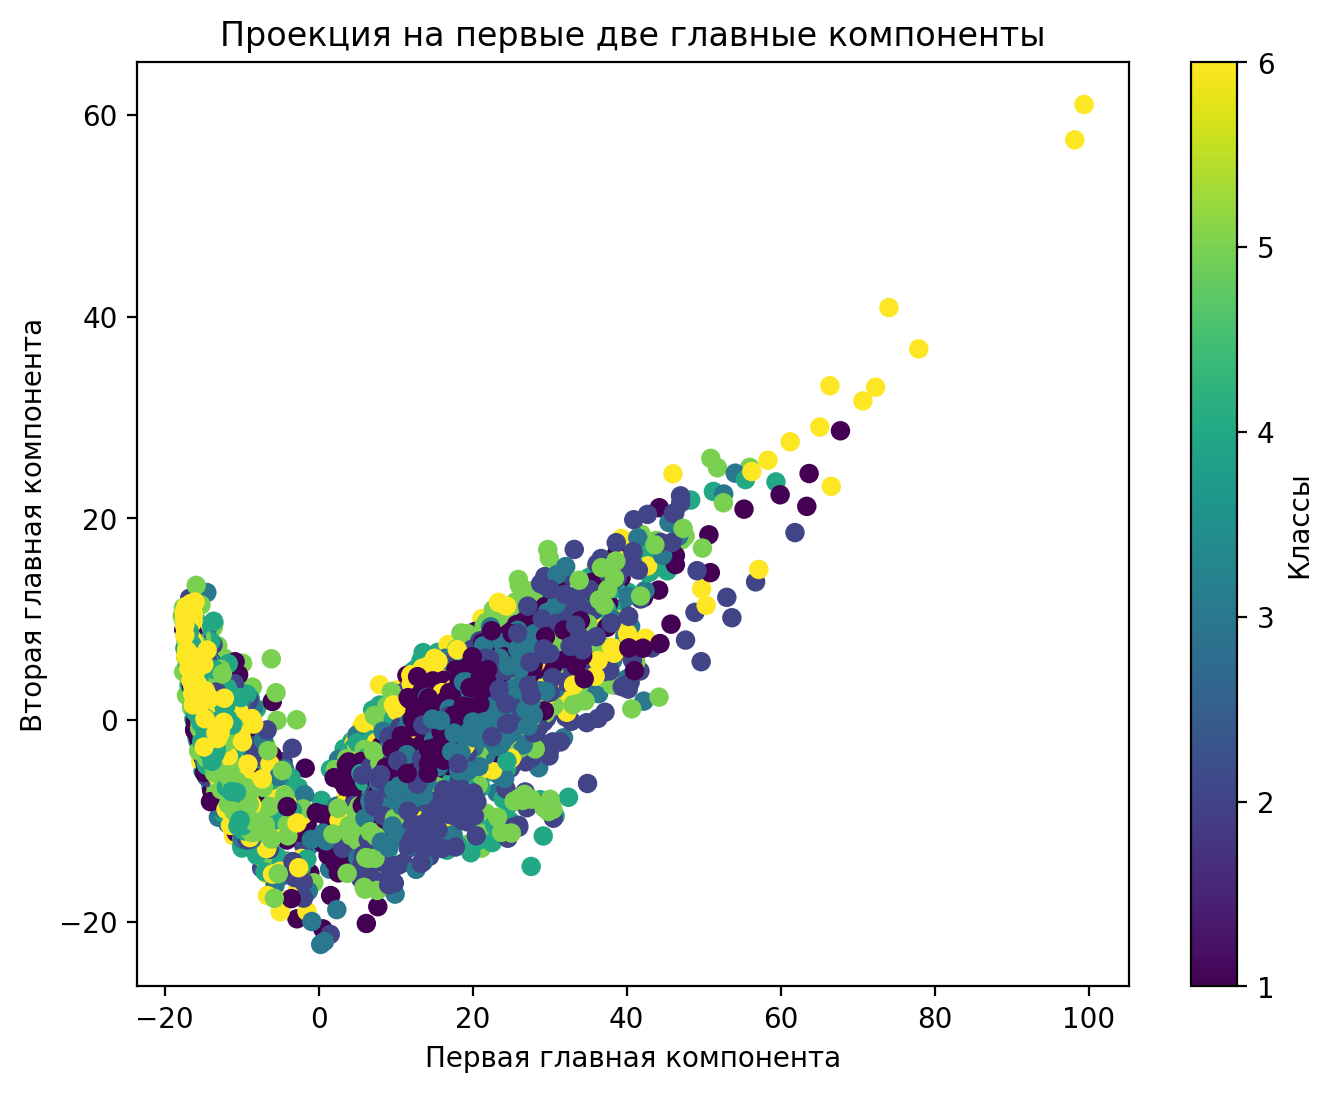

In [29]:
# Ваш код здесь
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values.ravel(), cmap="viridis")
plt.colorbar(label="Классы")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция на первые две главные компоненты")
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [30]:
import time
from sklearn.cluster import KMeans

n_clusters = 6
n_init = 100
kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=RANDOM_STATE)

start = time.time()
kmeans.fit(X_pca)
end = time.time()
print(f"Время обучения: {end-start:.4f} секунд")

start = time.time()
clusters = kmeans.predict(X_pca)
end = time.time()
print(f"Время инференса: {end-start:.4f} секунд")

Время обучения: 6.7316 секунд
Время инференса: 0.0021 секунд


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

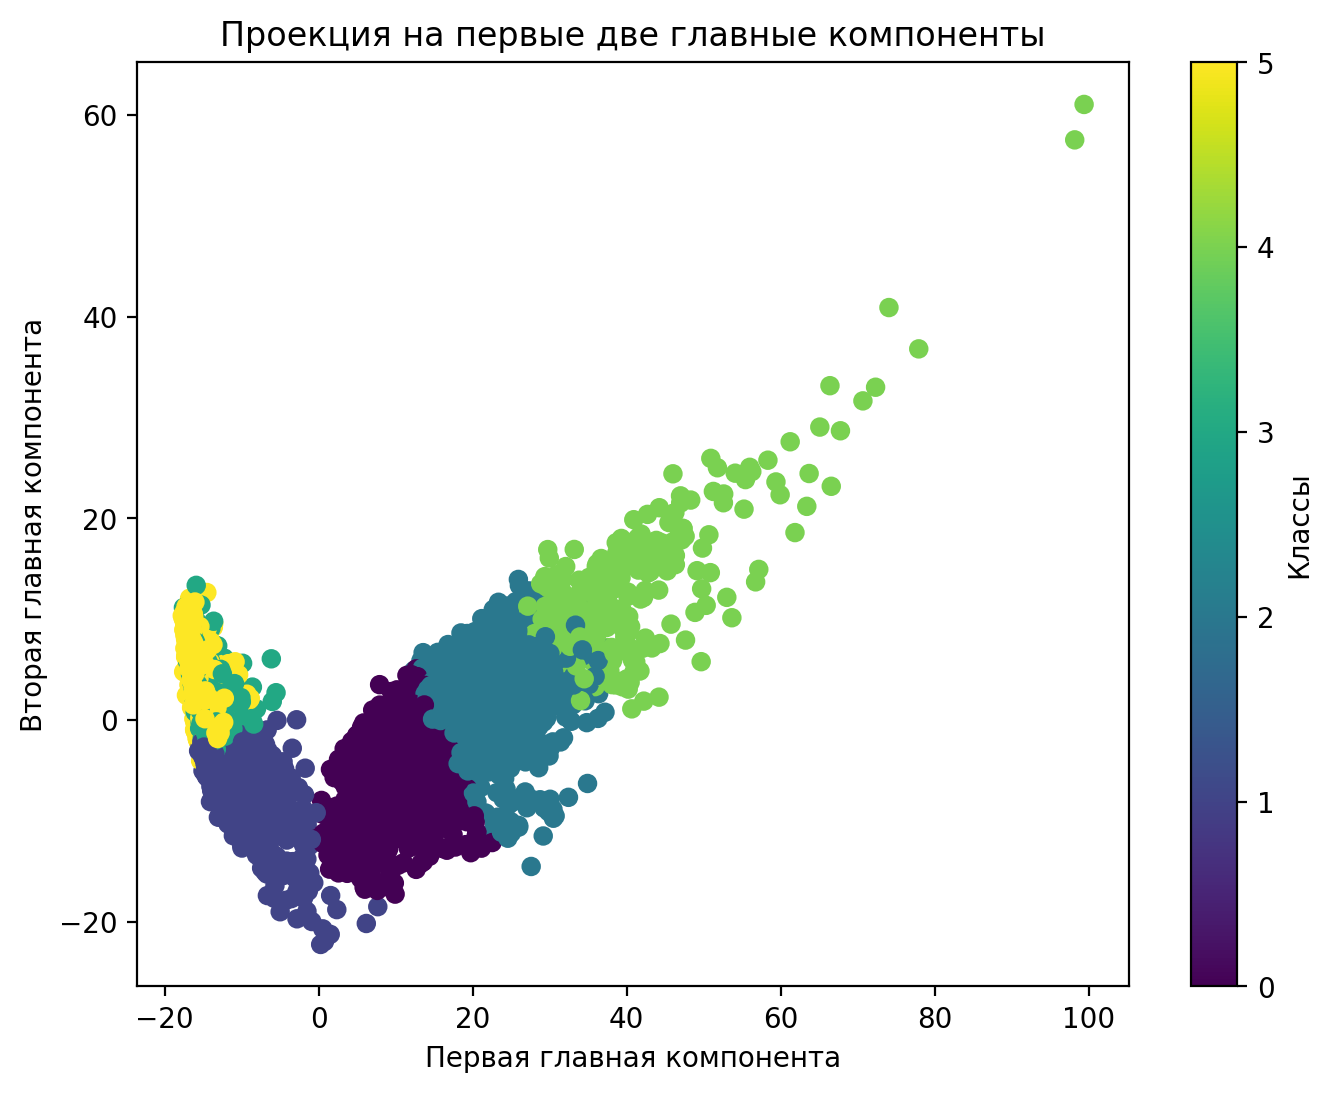

In [31]:
# Ваш код здесь
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.colorbar(label="Классы")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция на первые две главные компоненты")
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [32]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

ari = adjusted_rand_score(y.values.ravel(), clusters)
silhouette = silhouette_score(X_pca, clusters)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

Adjusted Rand Index: 0.0051
Silhouette Score: 0.1414


**Ваш вывод здесь**

KMeans плохо совпал с реальными классами (ARI = 0.005), а Silhouette Score = 0.14 показывает слабую кластерную структуру. Разбиение на кластеры получилось нечетким.

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [33]:
from sklearn.cluster import AgglomerativeClustering
import time

agg_clustering = AgglomerativeClustering(n_clusters=6)

start = time.time()
agg_clustering.fit(X_pca)
end = time.time()
print(f"Время обучения: {end-start:.4f} секунд")

start = time.time()
agg_clusters = agg_clustering.labels_
end = time.time()
print(f"Время инференса: {end-start:.4f} секунд")

ari = adjusted_rand_score(y.values.ravel(), agg_clusters)
silhouette = silhouette_score(X_pca, agg_clusters)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")


Время обучения: 2.0907 секунд
Время инференса: 0.0000 секунд
Adjusted Rand Index: 0.0043
Silhouette Score: 0.1366


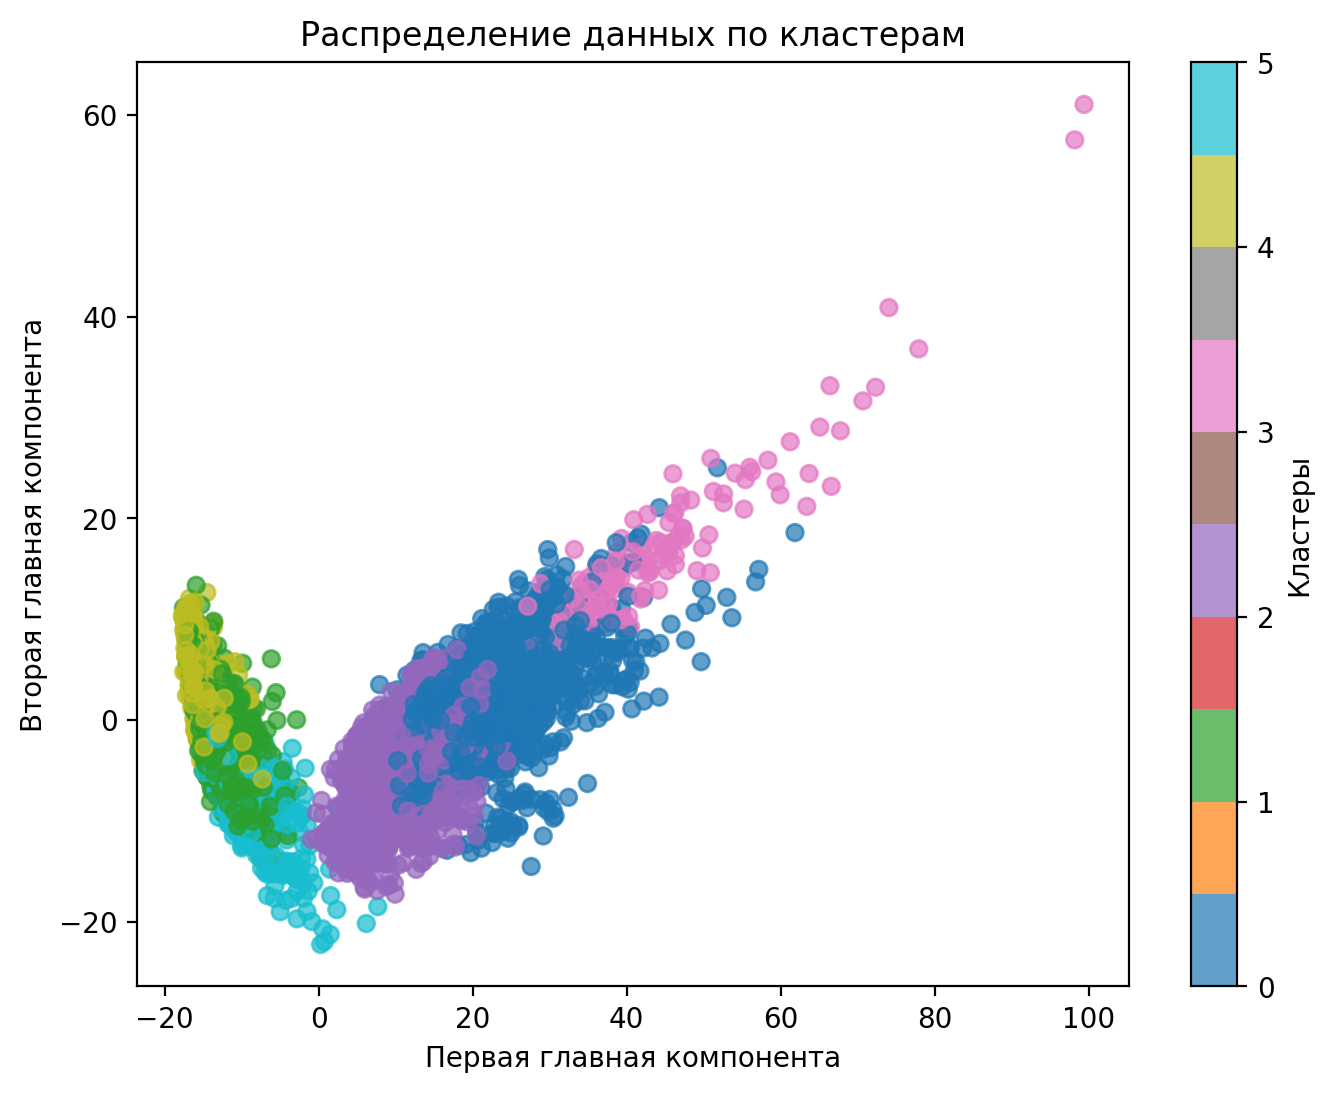

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_clusters, cmap="tab10", alpha=0.7)
plt.colorbar(label="Кластеры")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Распределение данных по кластерам")
plt.show()

**Ваш вывод здесь**

Кластеризация с помощью AgglomerativeClustering также плохо совпала с реальными классами (ARI = 0.0043), а Silhouette Score = 0.14 указывает на слабую структуру кластеров. Результаты схожи с KMeans - оба метода не справляются с разделением данных на осмысленные кластеры.


### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

1. Да, похожи. представляют схожие типы активности, так как похожие данные группируются вместе.
2. в 1 и 5 класс смешиваются активности, в 3 и 5. Смешивается активность из-за схожести в характеристиках
3. Кластеризация получилась не очень качественной, так как метрики, такие как ARI и Silhouette Score, показывают слабую структуру кластеров.

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

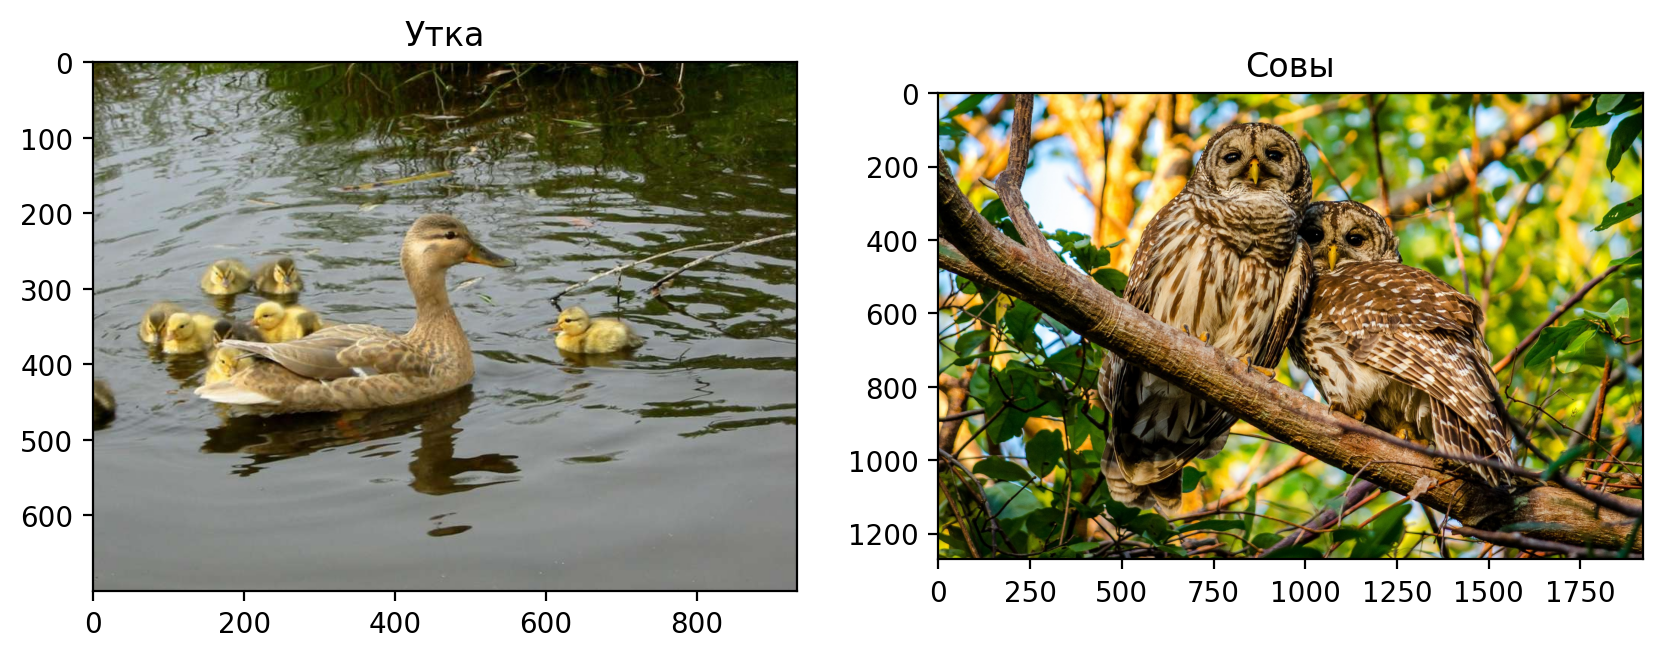

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

duck_image = Image.open('duck.jpg')
owls_image = Image.open('owls.jpg')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(duck_image)
plt.title('Утка')

plt.subplot(1, 2, 2)
plt.imshow(owls_image)
plt.title('Совы')

plt.show()

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

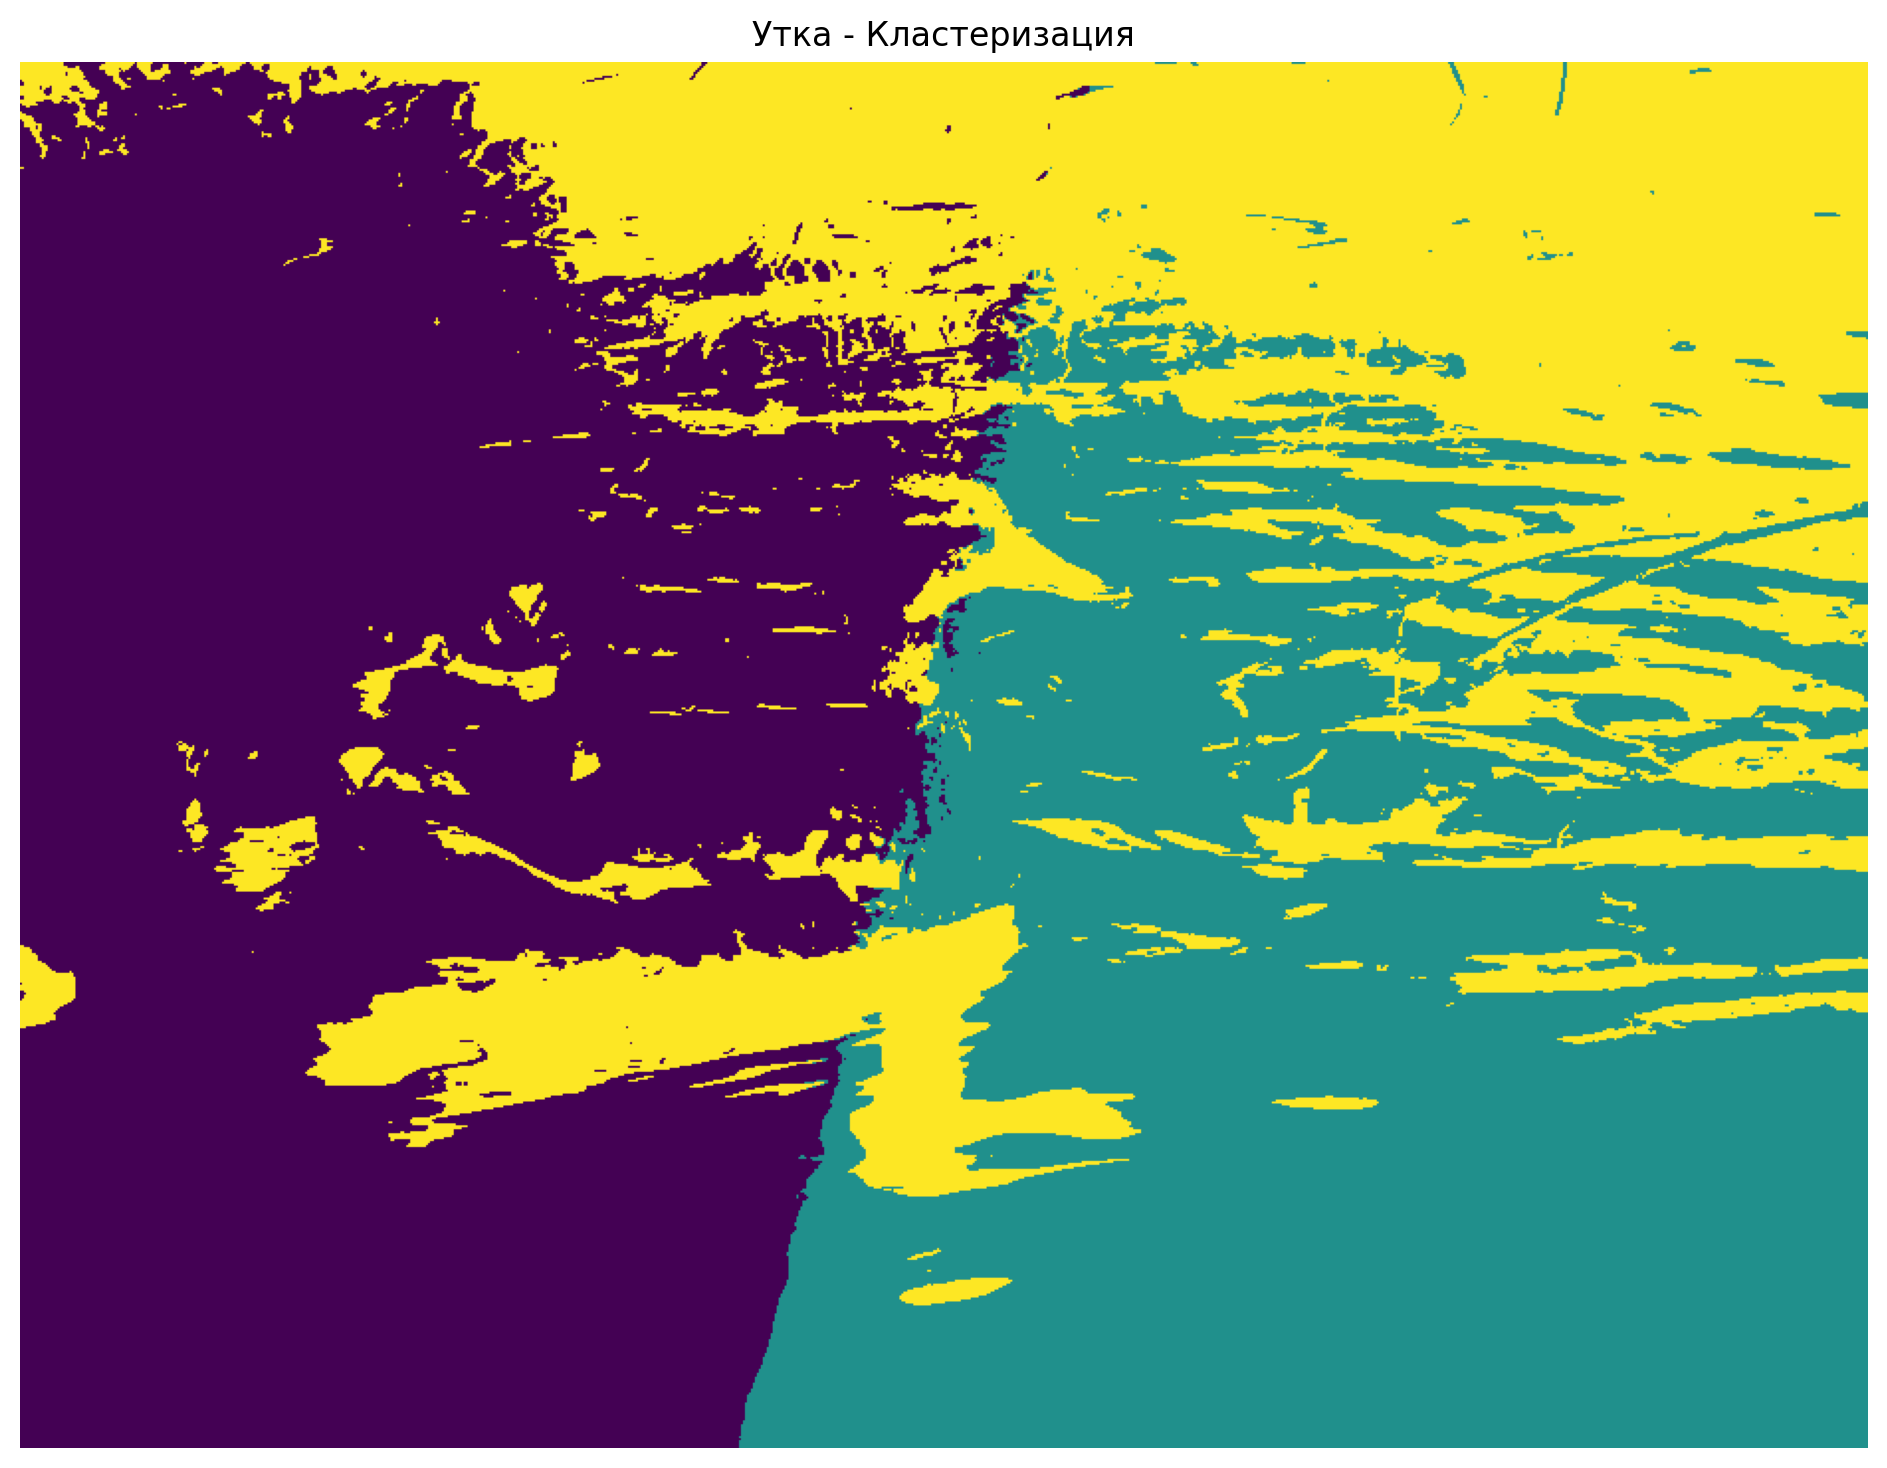

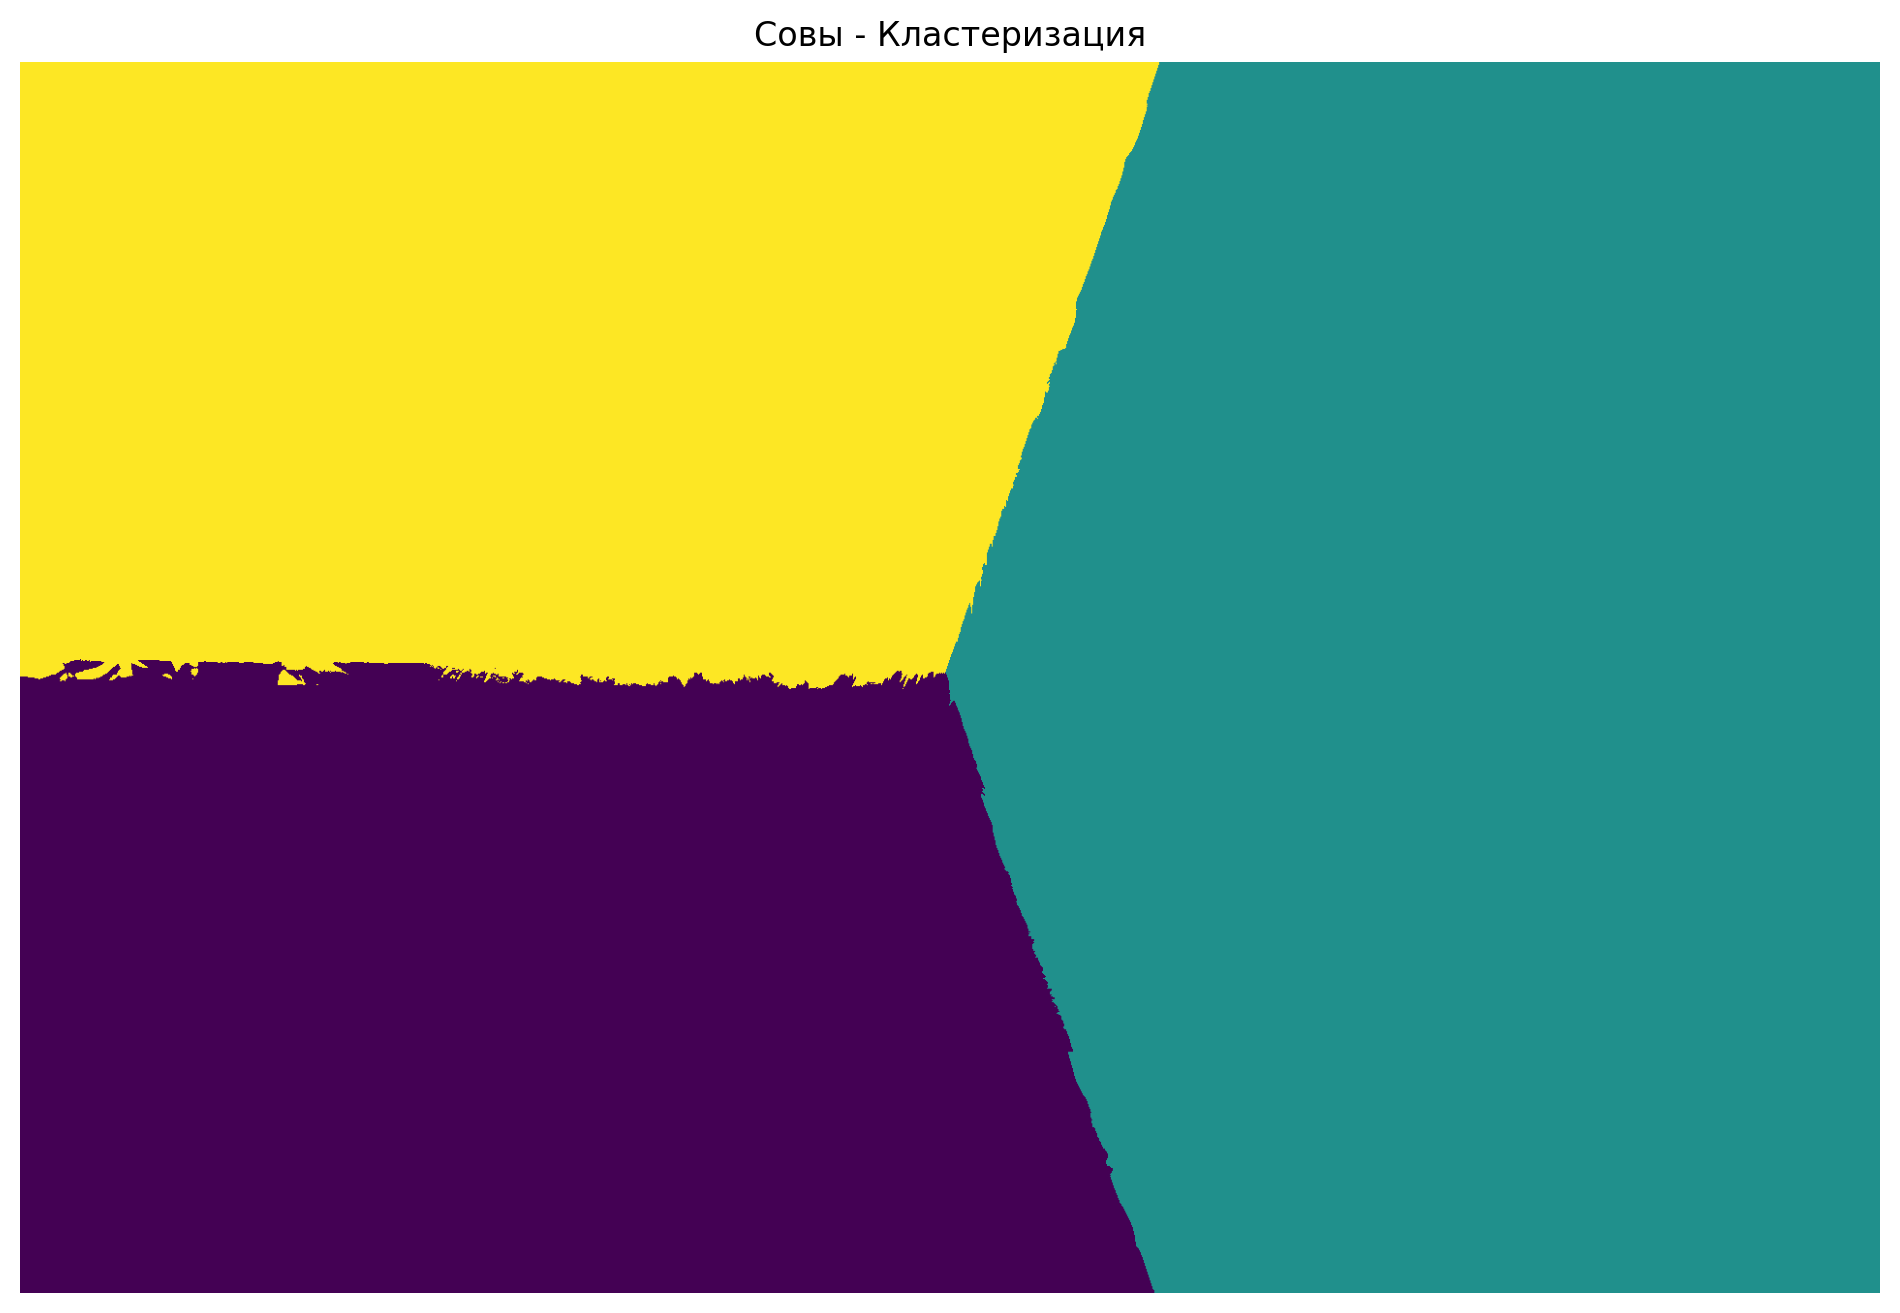

In [36]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt

def find_components(image, lmbd, n_clusters, title):
    pixels = np.array([[(lmbd * x, lmbd * y, *image.getpixel((x, y))) for x in range(image.width)] for y in range(image.height)])
    pixels = pixels.reshape((-1, 5))
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pixels)
    plt.imshow(labels.reshape(image.size[::-1]), cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

find_components(Image.open('duck.jpg'), 0.3, 3, "Утка - Кластеризация")
find_components(Image.open('owls.jpg'), 1.5, 3, "Совы - Кластеризация")
# загуглил как делать

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [37]:
# не догуглился, не поулчилось

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

In [22]:
# ее вышло(

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

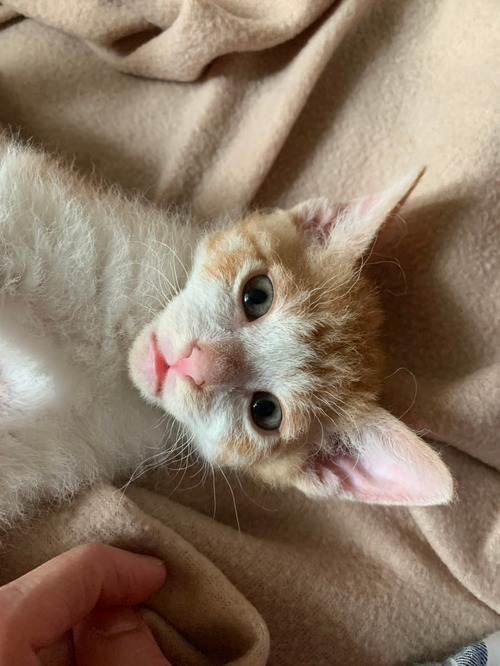

Кот хороший :)